
# PCA Mini-Project 
### Faces recognition example using eigenfaces and SVMs
Our discussion of PCA spent a lot of time on theoretical issues, so in this mini-project we’ll ask you to play around with some sklearn code. The eigenfaces code is interesting and rich enough to serve as the testbed for this entire mini-project.



Note:
The dataset used in this example is a preprocessed excerpt of the
"[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)", aka [LFW_ Download](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (233MB). [Original source](http://scikit-learn.org/0.15/auto_examples/applications/face_recognition.html).

In [1]:

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## Loading the dataset

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

/home/minhvu/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass data_home=data as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Split into a training and testing set

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Compute PCA

We can now compute a [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction.

In [4]:
n_components = 300

print( "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]) )
t0 = time()

# TODO: Create an instance of PCA, initializing with n_components=n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

#TODO: pass the training dataset (X_train) to pca's 'fit()' method
pca = pca.fit(X_train)


print("done in %0.3fs" % (time() - t0))

Extracting the top 300 eigenfaces from 966 faces
done in 1.708s


Projecting the input data on the eigenfaces orthonormal basis

In [5]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


done in 0.064s


## Train a SVM classification model

Let's fit a [SVM classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to the training set. We'll use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find a good set of parameters for the classifier.

In [6]:

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


## Evaluation of the model quality on the test set

#### 1. Classification Report
Now that we have the classifier trained, let's run it on the test dataset and qualitatively evaluate its results. Sklearn's [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) shows some of the main classification metrics for each class.

In [7]:
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.76      0.90      0.82        60
  Donald Rumsfeld       0.86      0.67      0.75        27
    George W Bush       0.86      0.90      0.88       146
Gerhard Schroeder       0.84      0.64      0.73        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.85      0.78      0.81        36

         accuracy                           0.82       322
        macro avg       0.79      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



#### 2. Confusion Matrix

Another way to look at the performance of the classifier is by looking the [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). We can do that by simply invoking [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

In [8]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  9   1   1   2   0   0   0]
 [  1  54   1   3   0   1   0]
 [  2   3  18   3   0   0   1]
 [  3   8   1 131   0   1   2]
 [  0   0   0   8  16   0   1]
 [  0   4   0   1   1   8   1]
 [  1   1   0   4   2   0  28]]


#### 3. Plotting The Most Significant Eigenfaces

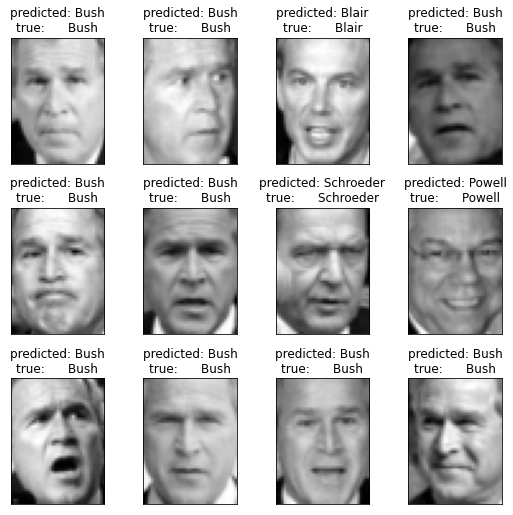

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())



# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()

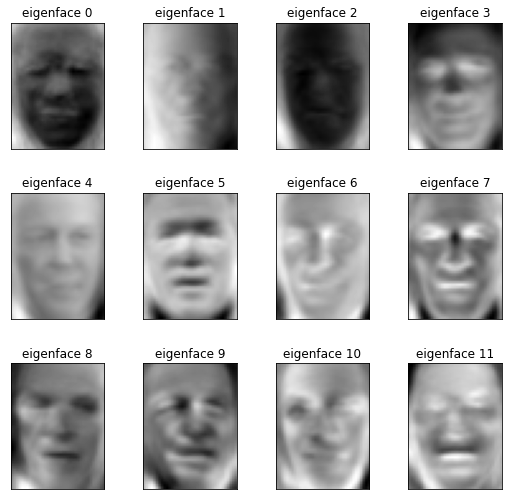

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()